In [24]:
import pvdeg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
front_range_map = pvdeg.scenario.GeospatialScenario(
    name='front_range_map',
)

front_range_map.addLocation(
    state='Colorado',
)   

# fix 2d array
front_range_map.location_bounding_box(
    coord_1=[39.419, -106.08],
    coord_2=[39.3257, -104.3115]
)

/home/tford/.conda-envs/pvdeg_env/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


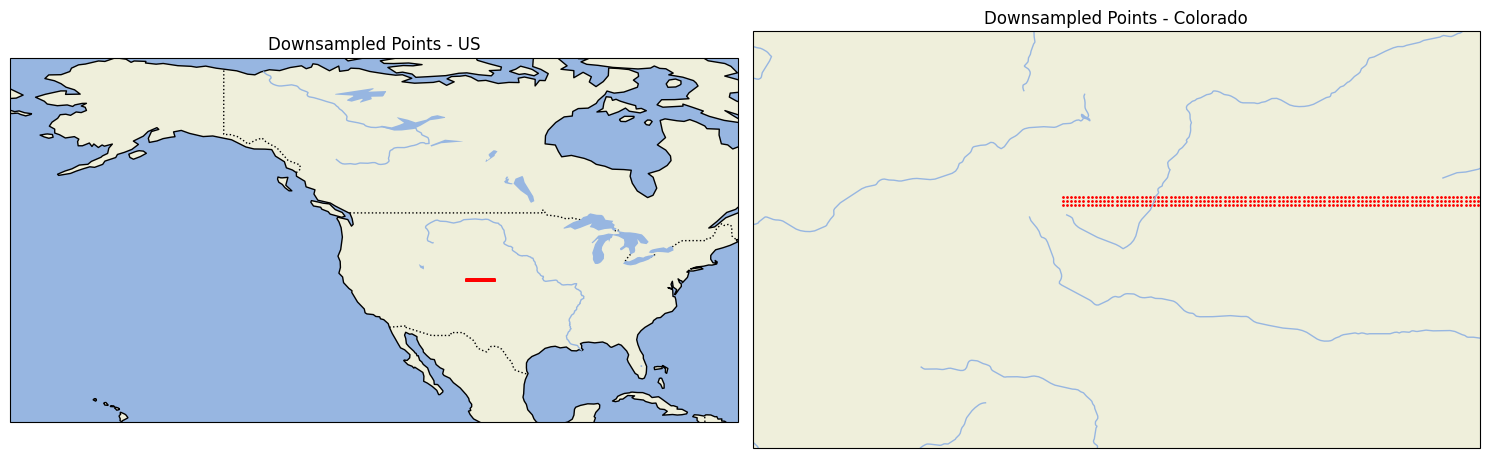

In [4]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot for the US
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.LAKES)
ax1.add_feature(cfeature.RIVERS)

US_bbox = (-171.791110603, 18.91619, -66.96466, 71.3577635769)
ax1.set_xlim(US_bbox[0], US_bbox[2])  # Set longitude limits
ax1.set_ylim(US_bbox[1], US_bbox[3])  # Set latitude limits

meta = front_range_map.meta_data
ax1.scatter(meta['longitude'], meta['latitude'], s=1, color='red', transform=ccrs.PlateCarree())
ax1.set_title('Downsampled Points - US')

# Plot for Colorado
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.LAKES)
ax2.add_feature(cfeature.RIVERS)

# Set to show all of Colorado using coordinates
min_long, max_long = -109.0452, -102.0416
min_lat, max_lat = 36.9931, 41.0034
ax2.set_extent([min_long, max_long, min_lat, max_lat], crs=ccrs.PlateCarree())

ax2.scatter(meta['longitude'], meta['latitude'], s=1, color='red', transform=ccrs.PlateCarree())
ax2.set_title('Downsampled Points - Colorado')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# front_range_map.addJob(
#     pvdeg.standards.standoff,
#     see_added=True
# )

In [ ]:
# front_range_map.run()

In [5]:
standoff_results = xr.open_dataset("front-range-standoff.nc").load() # want to load into memory rather than lazy using load()

In [4]:
standoff_results

<xarray.Dataset> Size: 8kB
Dimensions:    (latitude: 3, longitude: 101)
Coordinates:
  * latitude   (latitude) float32 12B 39.33 39.37 39.41
  * longitude  (longitude) float32 404B -106.1 -106.0 -106.0 ... -102.1 -102.1
Data variables:
    x          (latitude, longitude) float64 2kB 0.1565 0.0 0.0 ... 2.861 2.845
    T98_0      (latitude, longitude) float64 2kB 70.61 68.96 ... 78.55 78.52
    T98_inf    (latitude, longitude) float64 2kB 44.89 42.75 ... 54.54 54.49
Attributes:
    long_name:  Standoff dataset

In [6]:
standoff_results_gids = pvdeg.geospatial.restore_gids(
    front_range_map.meta_data,
    standoff_results
)

In [7]:
standoff_results_gids

<xarray.Dataset> Size: 10kB
Dimensions:    (latitude: 3, longitude: 101)
Coordinates:
  * latitude   (latitude) float32 12B 39.33 39.37 39.41
  * longitude  (longitude) float32 404B -106.1 -106.0 -106.0 ... -102.1 -102.1
Data variables:
    x          (latitude, longitude) float64 2kB 0.1565 0.0 0.0 ... 2.861 2.845
    T98_0      (latitude, longitude) float64 2kB 70.61 68.96 ... 78.55 78.52
    T98_inf    (latitude, longitude) float64 2kB 44.89 42.75 ... 54.54 54.49
    gid        (latitude, longitude) int64 2kB 457776 457777 ... 560793 560794
Attributes:
    long_name:  Standoff dataset

In [26]:
# now iterate through to get 3d points using elevation from meta[gid] and lat long for x and y then heatmap with elevation
gids = standoff_results_gids['gid'].values

gids_flat = gids.flatten() # flatten for indexing

altidues_flat = front_range_map.meta_data.loc[gids_flat, 'altitude'].values 

altitudes_2d = altidues_flat.reshape(gids.shape) # altitude array

https://stackoverflow.com/questions/23785408/3d-cartopy-similar-to-matplotlib-basemap
https://stackoverflow.com/questions/48269014/contourf-in-3d-cartopy%5D

https://www.geeksforgeeks.org/3d-heatmap-in-python/

https://github.com/opengeos/mapwidget

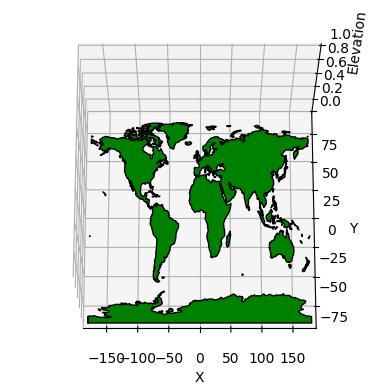

In [47]:
import itertools

from mpl_toolkits.mplot3d import Axes3D, art3d
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
import numpy as np

import cartopy.feature
from cartopy.mpl.patch import geos_to_path
import cartopy.crs as ccrs


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-180, 180])
ax.set_ylim([-90, 90])
ax.set_zlim([0, 1]) # elevation range will need to be different (could normalize)


concat = lambda iterable: list(itertools.chain.from_iterable(iterable))

target_projection = ccrs.PlateCarree()

feature = cartopy.feature.NaturalEarthFeature('physical', 'land', '110m')
geoms = feature.geometries()

geoms = [target_projection.project_geometry(geom, feature.crs)
         for geom in geoms]

paths = concat(geos_to_path(geom) for geom in geoms)

polys = concat(path.to_polygons() for path in paths)

# polys3d = [np.array(poly) for poly in polys if len(poly) > 0]
polys3d = [np.insert(np.array(poly), 2, values=0, axis=1) for poly in polys if len(poly) > 0]

lc = art3d.Poly3DCollection(polys3d, edgecolor='black', facecolor='green', closed=False)

ax.add_collection3d(lc)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Elevation')


# change viewing angle
ax.view_init(elev=70,azim=270)
plt.show()